# Topic Modeling and Sentiment Analysis

This document is for conducting LDA Topic Modeling on our dataset, and also explores the sentiment scores of the titles and the texts of the articles.

In [37]:
import pandas as pd
import numpy as np
from scipy.linalg import norm, eigh
from sklearn.decomposition import PCA
import plotly_express as px
from scipy.linalg import eigh
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from scipy.linalg import eigh
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA
import plotly_express as px
from gensim.models import word2vec
from sklearn.manifold import TSNE
from textblob import TextBlob

import warnings
warnings.filterwarnings('ignore')

In [4]:
data_in = "./data"

In [30]:
CORPUS = pd.read_csv(data_in+"/CORPUS.csv").drop("Unnamed: 0", axis=1).set_index(['source', 'text_num', 'para_num', 'sent_num', 'token_num'])
LIB = pd.read_csv(data_in+"/LIB.csv").set_index("source_id")
VOCAB = pd.read_csv(data_in+"/VOCAB.csv").set_index("term_str")

In [31]:
CORPUS.sample(5)

pos_tuple  pos  \
source text_num para_num sent_num token_num                              
CNN    63       3        0        32              ('said', 'VBD')  VBD   
       262      0        1        0                 ('try', 'VB')   VB   
       294      18       1        6          ('irrational', 'JJ')   JJ   
       94       6        0        31                ('and', 'CC')   CC   
CNBC   510      33       2        10                  ('a', 'DT')   DT   

                                              token_str    term_str  
source text_num para_num sent_num token_num                          
CNN    63       3        0        32               said        said  
       262      0        1        0                 try         try  
       294      18       1        6          irrational  irrational  
       94       6        0        31                and         and  
CNBC   510      33       2        10                  a           a

In [32]:
OHCO = ['source', 'text_num', 'para_num', 'sent_num', 'token_num']
SENTS = OHCO[:4]
PARAS = OHCO[:3]
ARTICLES = OHCO[:2]
SOURCES = OHCO[:1]

In [33]:
# parameters for the topic model
ngram_range = (1,2)
max_features = 4000 # CountVectorizer max features parameter
stop_words = 'english'
n_components = 20
max_iter = 5
learning_offset = 50.
random_state = 0
num_words_to_characterize = 7 

In [34]:
def topic_model_generator(BAG, TOKENS):
    # filter for nouns (NN and NNS hyperparameters)
    DOCS = TOKENS[TOKENS.pos.isin(['NN','NNS'])]\
        .groupby(BAG).term_str\
        .apply(lambda x: ' '.join(x))\
        .to_frame()\
        .rename(columns={'term_str':'doc_str'})
    
    # create vector space
    count_engine = CountVectorizer(max_features=max_features, ngram_range=ngram_range, stop_words=stop_words)
    count_model = count_engine.fit_transform(DOCS.doc_str)
    TERMS = count_engine.get_feature_names_out()
    VOCAB = pd.DataFrame(index=TERMS)
    VOCAB.index.name = 'term_str'
    DTM = pd.DataFrame(count_model.toarray(), index=DOCS.index, columns=TERMS)
    VOCAB['doc_count'] = DTM.astype('bool').astype('int').sum()
    DOCS['term_count'] = DTM.sum(1)
    
    # generate moddel
    lda_engine = LDA(n_components=n_components, max_iter=max_iter, learning_offset=learning_offset, random_state=random_state)
    
    # topic names
    TNAMES = [f"T{str(x).zfill(len(str(n_components)))}" for x in range(n_components)]
    
    # THETA
    lda_model = lda_engine.fit_transform(count_model)
    THETA = pd.DataFrame(lda_model, index=DOCS.index)
    THETA.columns.name = 'topic_id'
    THETA.columns = TNAMES
    
    # PHI
    PHI = pd.DataFrame(lda_engine.components_, columns=TERMS, index=TNAMES)
    PHI.index.name = 'topic_id'
    PHI.columns.name  = 'term_str'
    
    # inspect results
    # create TOPICS & get Top Terms per Topic
    TOPICS = PHI.stack().to_frame('topic_weight').groupby('topic_id')\
        .apply(lambda x: x.sort_values('topic_weight', ascending=False)\
        .head(num_words_to_characterize).reset_index().drop('topic_id', axis=1)['term_str'])
    TOPICS['label'] = TOPICS.apply(lambda x: x.name + ' ' + ', '.join(x[:num_words_to_characterize]), 1)
    
    
    # sort topics by Doc Weight
    TOPICS['doc_weight_sum'] = THETA.sum()
    TOPICS['term_freq'] = PHI.sum(1) / PHI.sum(1).sum()
    
    return THETA, PHI, TOPICS

In [24]:
scene_as_bag = ARTICLES
THETA_PARA, PHI_PARA, TOPICS_PARA = topic_model_generator(scene_as_bag, CORPUS)

In [26]:
colors = "YlGnBu"
THETA_PARA.sample(20).style.background_gradient(cmap=colors, axis=None)

In [27]:
TOPICS_PARA

term_str,0,1,2,3,4,5,6,label,doc_weight_sum,term_freq
topic_id,,,,,,,,,,
T00,police,people,family,taylor,officers,cnn,life,"T00 police, people, family, taylor, officers, ...",69.222423,0.049714
T01,share,checks,people,cents,revenue,premarket,cents share,"T01 share, checks, people, cents, revenue, pre...",33.457869,0.030492
T02,trump,court,president,justice,department,law,case,"T02 trump, court, president, justice, departme...",59.098367,0.070633
T03,tax,taxes,world,states,year,scientists,people,"T03 tax, taxes, world, states, year, scientist...",32.798044,0.025902
T04,people,group,children,health,activity,women,adults,"T04 people, group, children, health, activity,...",27.990425,0.025968
T05,biden,president,policy,women,trump,years,country,"T05 biden, president, policy, women, trump, ye...",32.265093,0.032680
T06,companies,company,cramer,year,time,business,market,"T06 companies, company, cramer, year, time, bu...",60.442268,0.044070
T07,president,house,trump,presidents,health,president donald,donald,"T07 president, house, trump, presidents, healt...",28.054252,0.044080
T08,money,house,benefits,tax,democrats,relief,week,"T08 money, house, benefits, tax, democrats, re...",84.779509,0.082605


In [28]:
PHI_PARA.T.sample(20).style.background_gradient(cmap=colors, axis=None)

topic_id,T00,T01,T02,T03,T04,T05,T06,T07,T08,T09,T10,T11,T12,T13,T14,T15,T16,T17,T18,T19
term_str,,,,,,,,,,,,,,,,,,,,
worlds,1.717856,0.050000,0.050000,6.468524,0.050000,4.808049,13.127132,0.383793,0.050001,4.578936,0.050000,0.050000,0.050000,4.265284,0.050000,0.050425,0.050000,0.050000,0.050000,0.050000
victims,0.050000,4.796803,4.124852,2.303197,0.050000,0.050000,0.050000,0.050000,0.050000,2.739717,0.050000,0.050000,0.050000,0.050000,0.050000,1.425208,0.360283,0.050000,15.599940,0.050000
committees,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,7.050000,0.436627,0.050000,0.050000,0.050000,0.050000,0.050000,0.627506,0.050000,4.939185,0.050000,5.196660,0.050022
earnings season,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,24.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000
aircraft,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,3.811485,0.050000,0.050000,0.050000,0.050000,0.050000,8.288515,0.050000,0.050000,0.050000,0.050000
capacity,0.290295,0.239459,0.050000,0.050021,0.050000,5.715156,0.050000,8.304709,9.010101,16.756059,3.764000,0.050000,2.821620,0.270207,4.459149,0.196326,9.172525,2.219811,3.310650,3.219911
mcconnell,0.050000,0.050000,0.200551,0.051420,0.050000,0.050000,0.050017,27.325789,59.901536,0.050000,13.722792,0.050000,8.885114,0.079283,0.050000,0.050000,0.050000,0.050000,7.233498,0.050002
covid relief,0.050000,0.050000,0.050000,0.050278,0.050000,0.050000,0.050000,0.050000,30.848478,0.050000,0.050000,0.050000,0.235568,0.050000,0.050000,0.050000,1.065676,0.050000,0.050000,0.050000
year date,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,3.278813,0.050000,0.050000,0.050000,0.050000,0.050000,0.050000,8.547558,0.050000,0.074446,0.050000,0.050161,0.050000,0.299021


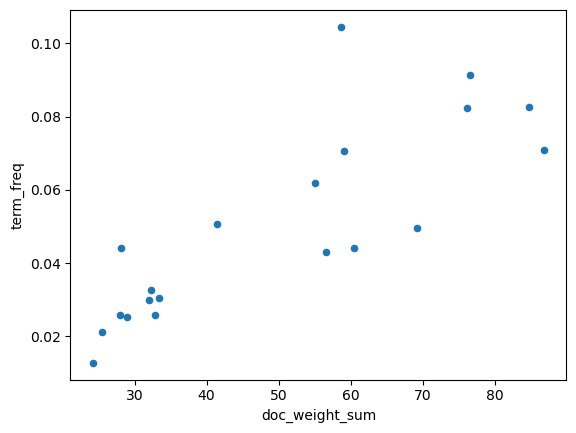

In [29]:
TOPICS_PARA.plot.scatter('doc_weight_sum', 'term_freq');

### Sentiment Analysis

In [40]:
LIB['article_subj'], LIB['article_pola'] = [LIB.text.apply\
                                                              (lambda x: TextBlob(str(x)).sentiment.subjectivity),\
                                                              LIB.text.apply(lambda x: TextBlob(str(x)).\
                                                                                           sentiment.polarity)]

In [43]:
LIB['title_subj'], LIB['title_pola'] = [LIB.title.apply(lambda x: TextBlob(str(x)).sentiment.subjectivity),\
                                                              LIB.title.apply(lambda x: TextBlob(str(x)).\
                                                                                           sentiment.polarity)]

In [52]:
LIB = LIB.reset_index()

In [55]:
CNN = LIB[LIB["source_id"] == "CNN"]
CNBC = LIB[LIB["source_id"] == "CNBC"]

In [66]:
trump_cnn = CNN[~CNN["text"].str.contains("trump", case=False)]
trump_cnbc = CNBC[~CNBC["text"].str.contains("trump", case=False)]
biden_cnn = CNN[~CNN["text"].str.contains("biden", case=False)]
biden_cnbc = CNBC[~CNBC["text"].str.contains("biden", case=False)]

In [73]:
a = trump_cnn[['article_subj','article_pola', 'title_subj', 'title_pola']].mean().to_frame("trump_cnn")

In [74]:
b = trump_cnbc[['article_subj','article_pola', 'title_subj', 'title_pola']].mean().to_frame("trump_cnbc")

In [75]:
c = biden_cnn[['article_subj','article_pola', 'title_subj', 'title_pola']].mean().to_frame("biden_cnn")

In [76]:
d = biden_cnbc[['article_subj','article_pola', 'title_subj', 'title_pola']].mean().to_frame("biden_cnbc")

In [77]:
frame = pd.concat([a,b,c,d], axis=1)
frame

,trump_cnn,trump_cnbc,biden_cnn,biden_cnbc
article_subj,0.438125,0.422608,0.431766,0.419098
article_pola,0.113012,0.107076,0.099330,0.102866
title_subj,0.447583,0.444345,0.451283,0.462784
title_pola,0.098883,0.085039,0.053813,0.050319


In [50]:
LIB[['article_subj', 'article_pola','title_subj', 'title_pola']].corr()

,article_subj,article_pola,title_subj,title_pola
article_subj,1.000000,0.141068,0.252238,0.145069
article_pola,0.141068,1.000000,0.006667,0.225899
title_subj,0.252238,0.006667,1.000000,0.080705
title_pola,0.145069,0.225899,0.080705,1.000000
